### Cardiovascular disease risk prediction using machine learning (ML) and deep learning (DL) models 

#### Importing important modules

In [1]:
#Importing modules
import pysurvival
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pysurvival
from pysurvival.datasets import Dataset
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#### Random seed and reproducibility 

In [2]:
import torch
import random
import numpy as np
import os
def seed_everything(seed=42):
 """"
 Seed everything.
 """ 
 random.seed(seed)
 os.environ['PYTHONHASHSEED'] = str(seed)
 np.random.seed(seed)
 torch.manual_seed(seed)
 torch.cuda.manual_seed(seed)
 torch.cuda.manual_seed_all(seed)
 torch.backends.cudnn.deterministic = True
SEED = 12345678 #random.randint(0,100000)
print(SEED)
seed_everything(SEED)

12345678


#### Importing impotant libraries to train the ML and DL models

In [3]:
###importing important libraries
####Models
from pysurvival.models.semi_parametric import CoxPHModel #cox proportional hazard
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival.models.multi_task import LinearMultiTaskModel  #Linear Multi Task logistic regression Models
from pysurvival.models.multi_task import NeuralMultiTaskModel #Neural -Multitask Logistic Regression
from pysurvival.models.semi_parametric import NonLinearCoxPHModel  ##NonLinear CoxPH model(DeepSurv)
from pysurvival.models.svm import LinearSVMModel
from pysurvival.models.svm import KernelSVMModel
###evaluation metrics
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import compare_to_actual
### ReaptedKF
from sklearn.model_selection import RepeatedKFold

In [4]:
def evaluate(model, X, T, E, model_name=""):
    errors=compare_to_actual(model, X, T, E, is_at_risk=True)
    c_index=concordance_index(model, X, T, E)
    ibs=integrated_brier_score(model, X, T, E)
    metrics={'c-index': c_index, 'IBS':ibs}
    eval_df=pd.DataFrame(data={**metrics, **errors}, index=[model_name])
    return eval_df.rename(columns={'root_mean_squared_error':'RMSE',
                                   'median_absolute_error':'MADE',
                                    'mean_absolute_error': 'MAE'})

In [5]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### Loading the dataset 

In [6]:
dtafile='A:/Objective 3/Replication_Jo_paper/Johannes_Imputed.dta'
dJh=pd.read_stata(dtafile)
dJh.head(5)

,BL_HDL_mmolL,BL_TC_mmolL,BL_Cr_mgDL,AgeAtRand,BL_SBP_Mean,bl_antihyp,Diab_deriv,BL_SmHis,Gender,MACE,MACE_DSR,non_HDL_C,fyear,Smoking
0,1.0,5.1,1.5,72.58,153.0,1,0,3,0,0,3044.0,4.1,8.334018,0
1,1.5,6.4,1.0,86.08,145.0,1,0,3,1,0,3089.0,4.9,8.457221,0
2,1.9,6.0,1.1,71.39,132.0,0,0,1,0,1,2465.0,4.1,6.748802,1
3,1.2,6.6,1.0,72.93,127.0,1,0,3,1,0,3564.0,5.4,9.757700,0
4,1.8,6.4,0.8,85.48,177.0,0,0,3,1,0,812.0,4.6,2.223135,0


In [7]:
dJh.rename(columns={'BL_HDL_mmolL': 'HDL_Cholesterol', 'BL_Cr_mgDL':'Serum creatinine', 'AgeAtRand': 'Age', 
                   'BL_SBP_Mean':'Systolic blood pressure', 'bl_antihyp': 'Antihypertensive medication use', 'Diab_deriv': 'Diabetes', 'non_HDL_C': 'Non_HDL_cholesterol'}, inplace=True)

In [8]:
dJh_Final=dJh[['Age', 'Gender', 'HDL_Cholesterol', 'Serum creatinine', 'Systolic blood pressure', "Antihypertensive medication use",
           'Diabetes', 'Non_HDL_cholesterol', 'Smoking', 'MACE', 'fyear']]

In [9]:
time_column='fyear'
event_column='MACE'
features_full= np.setdiff1d(dJh_Final.columns, [time_column, event_column]).tolist()

In [10]:
N_null=sum(dJh_Final[features_full].isnull().sum())
print("the dataset contains {} null values".format(N_null))
N=dJh_Final.shape[0]

the dataset contains 0 null values


#### Splitting the dataset into training and testing
 ##### This is done following the necessary data preprocesing
 For example:

  - Missing data/values were managed using Missforest method in R
  - In this study, variables were either binary or continuous. For continuous variables standard scaling was applied; however, the performances and results of the models, with scaling vs without scaling, were the same. Therefore, scaling was ignored for simplicity. 

In [11]:
from sklearn.model_selection import train_test_split
index_train, index_test=train_test_split(range(N), test_size=0.3, random_state=SEED)
data_train=dJh_Final.loc[index_train].reset_index(drop=True)
data_test=dJh_Final.loc[index_test].reset_index(drop=True)
###creating the X, T, and E inputs
X_train, X_test=data_train[features_full], data_test[features_full]
T_train, T_test=data_train[time_column], data_test[time_column]
E_train, E_test=data_train[event_column], data_test[event_column]

### Training of the models
The following models were trained and evaluated 
  1) Standard Cox proportional hazards model
  2) Random Survival Forest (RSF)
  3) Neural Multi-Task Logistic Regression (NMTLR), and
  4) Non-linear Cox proportional hazards (DeepSurv) models

- The neural architecture and other important hyperparametrs for the deep learning models were decided using random search method, involving 1,000 iterations with five fold cross-validation on the traing data. 

#### 1) Cox proportional hazards model

In [12]:
## Training using training data
Cox = CoxPHModel()
# Fitting the model
Cox.fit(X_train, T_train, E_train, verbose=False)

CoxPHModel

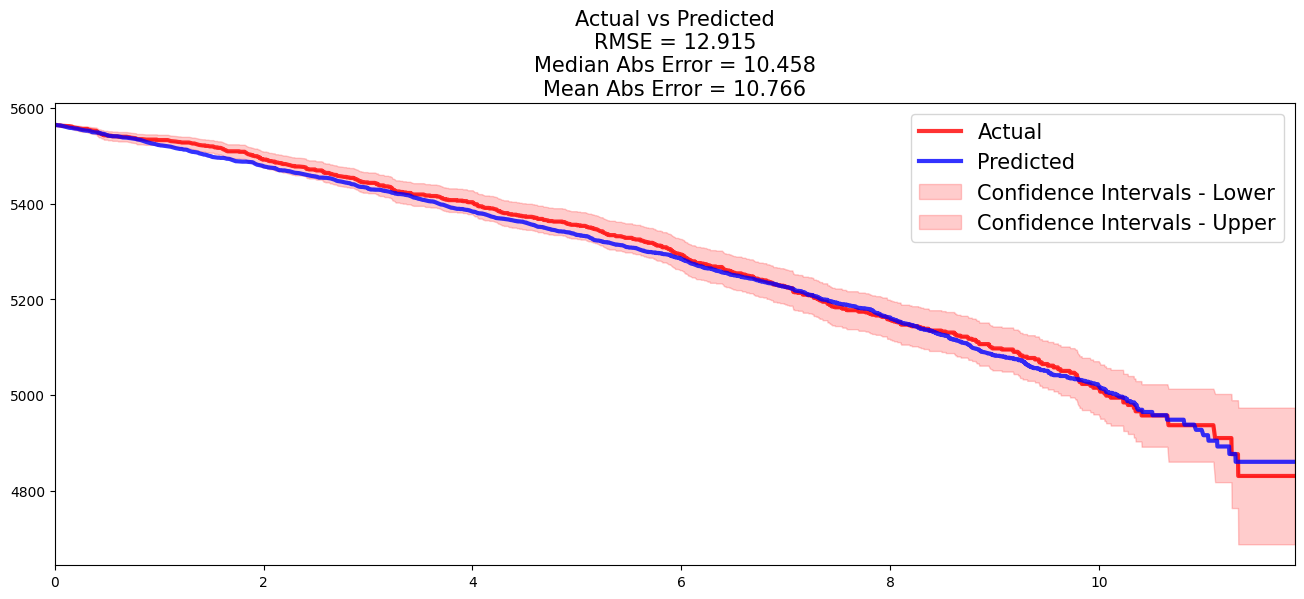

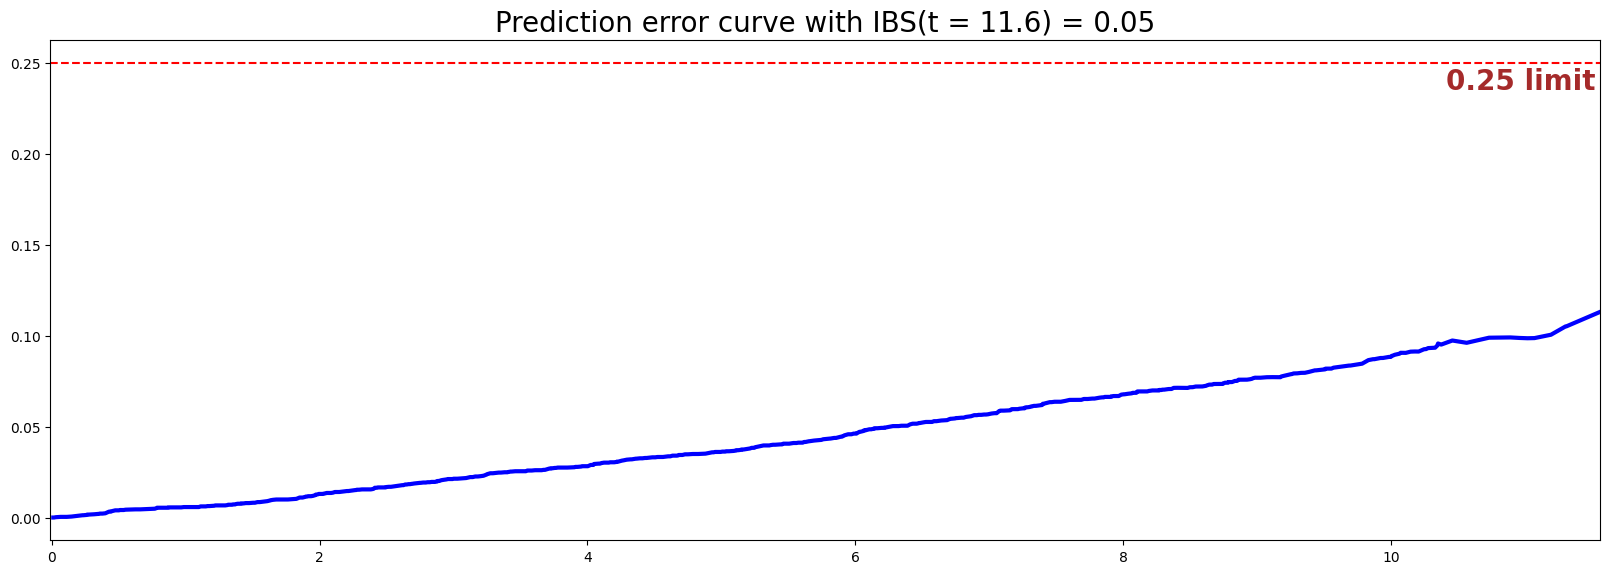

,c-index,IBS,RMSE,MADE,MAE
Cox,0.634651,0.047579,12.915428,10.458396,10.765946


In [13]:
## Model evaluation 
eval_Cox=evaluate(Cox, X_test, T_test, E_test, model_name ="Cox")
eval_Cox

#### 2) Random Survival Forest (RSF)

In [34]:
###Traing using training data
RSF=RandomSurvivalForestModel()
RSF.fit(X_train, T_train, E_train)

RandomSurvivalForestModel

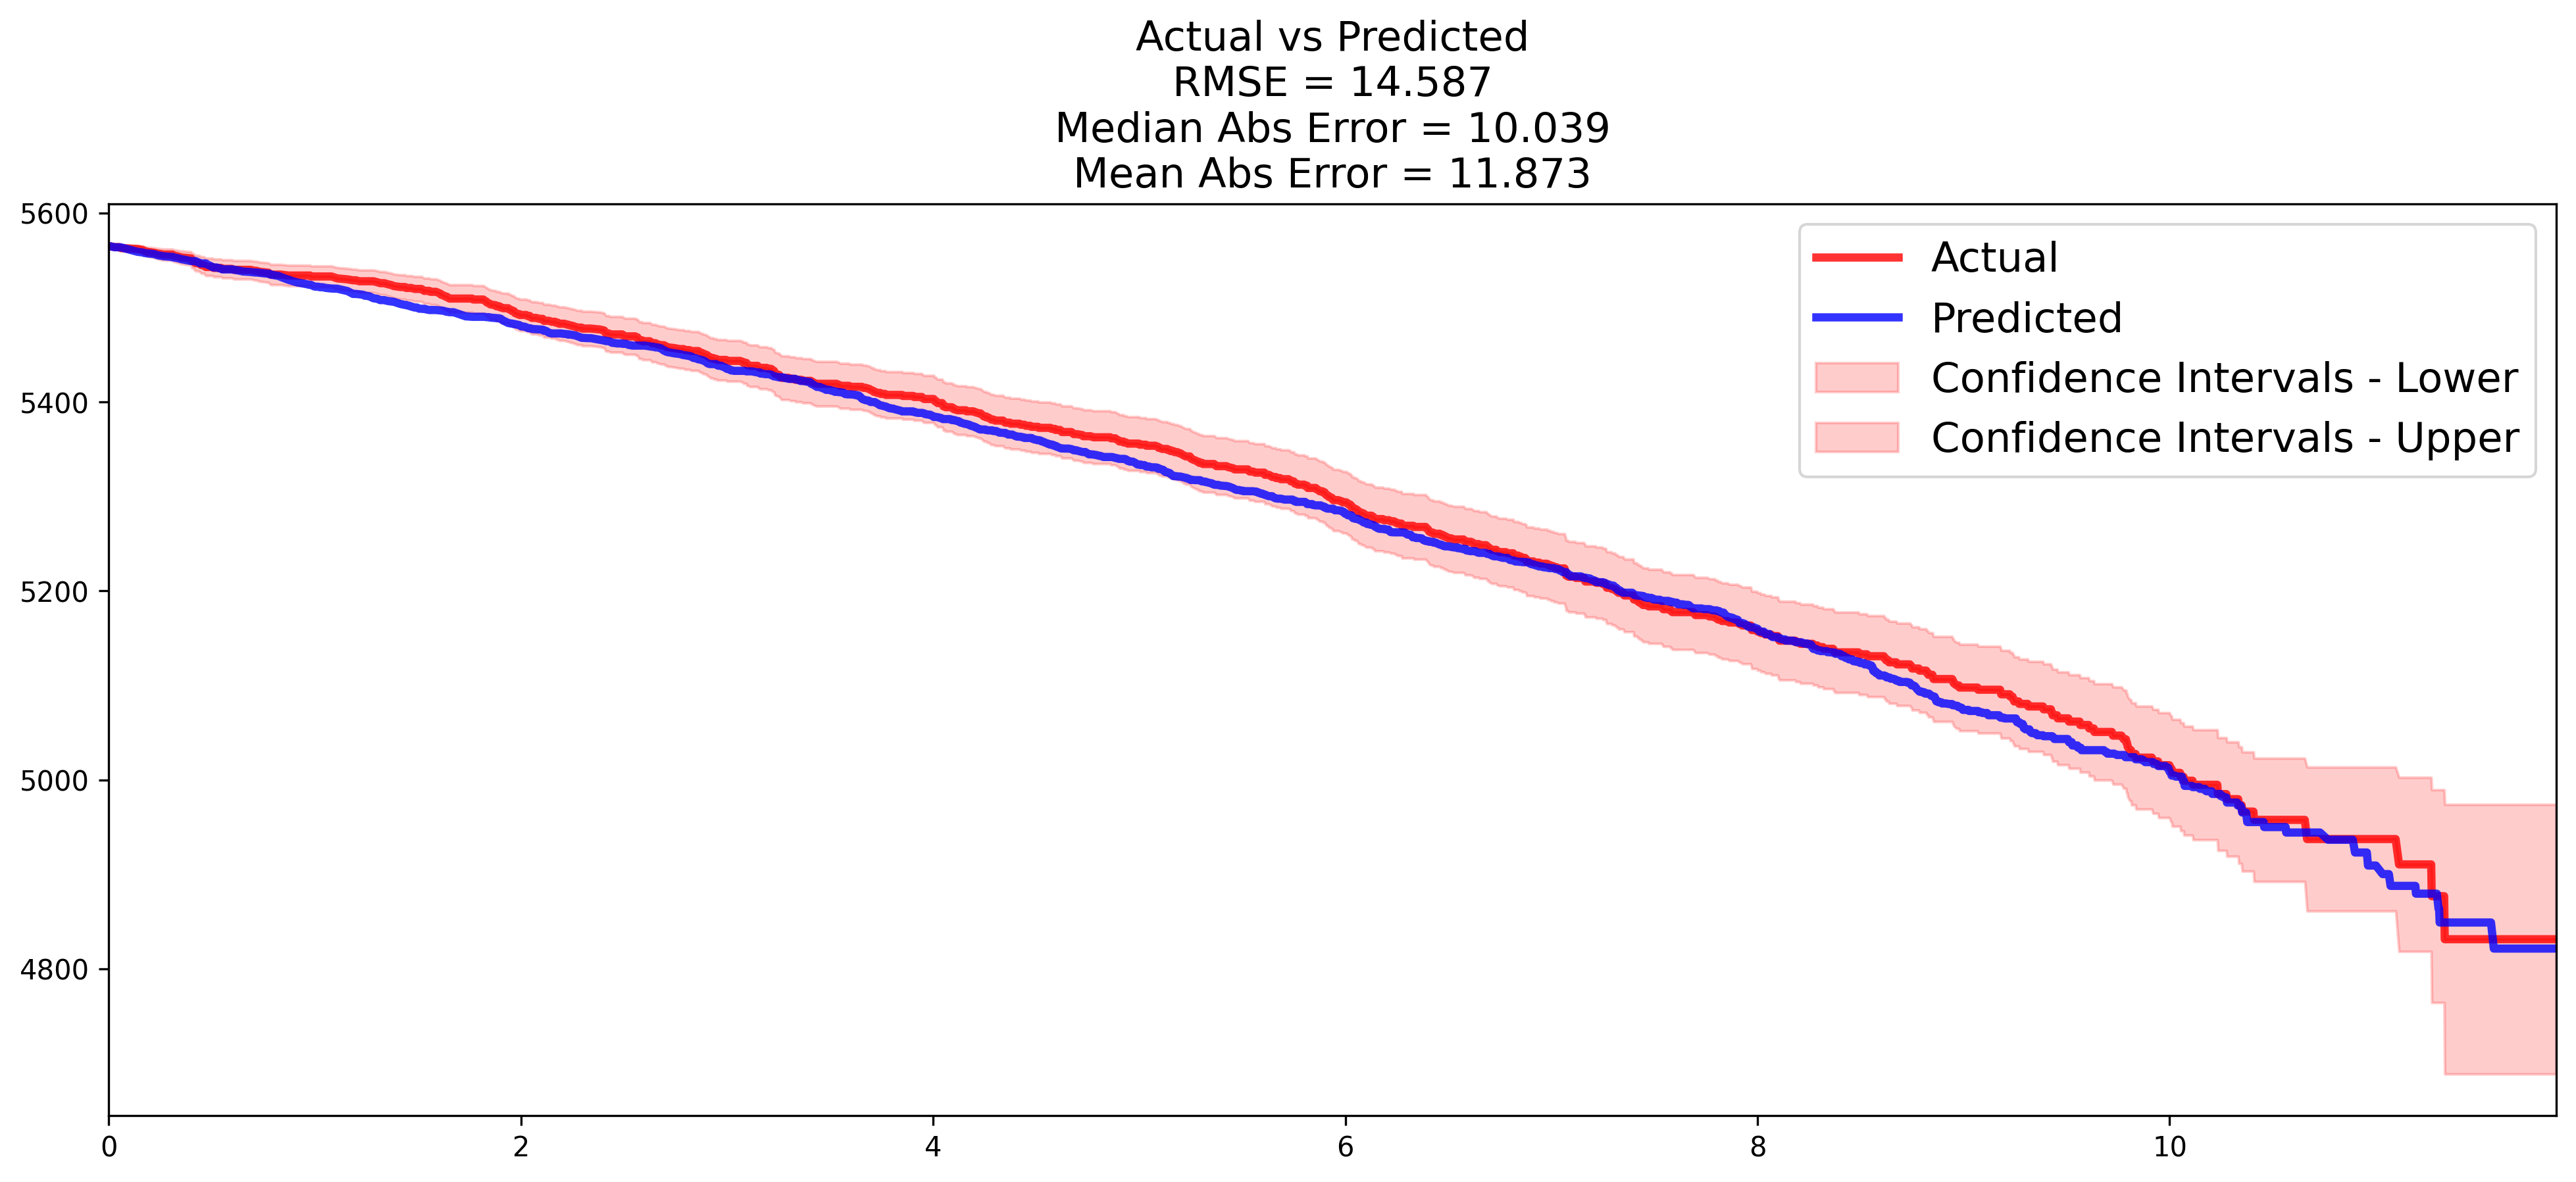

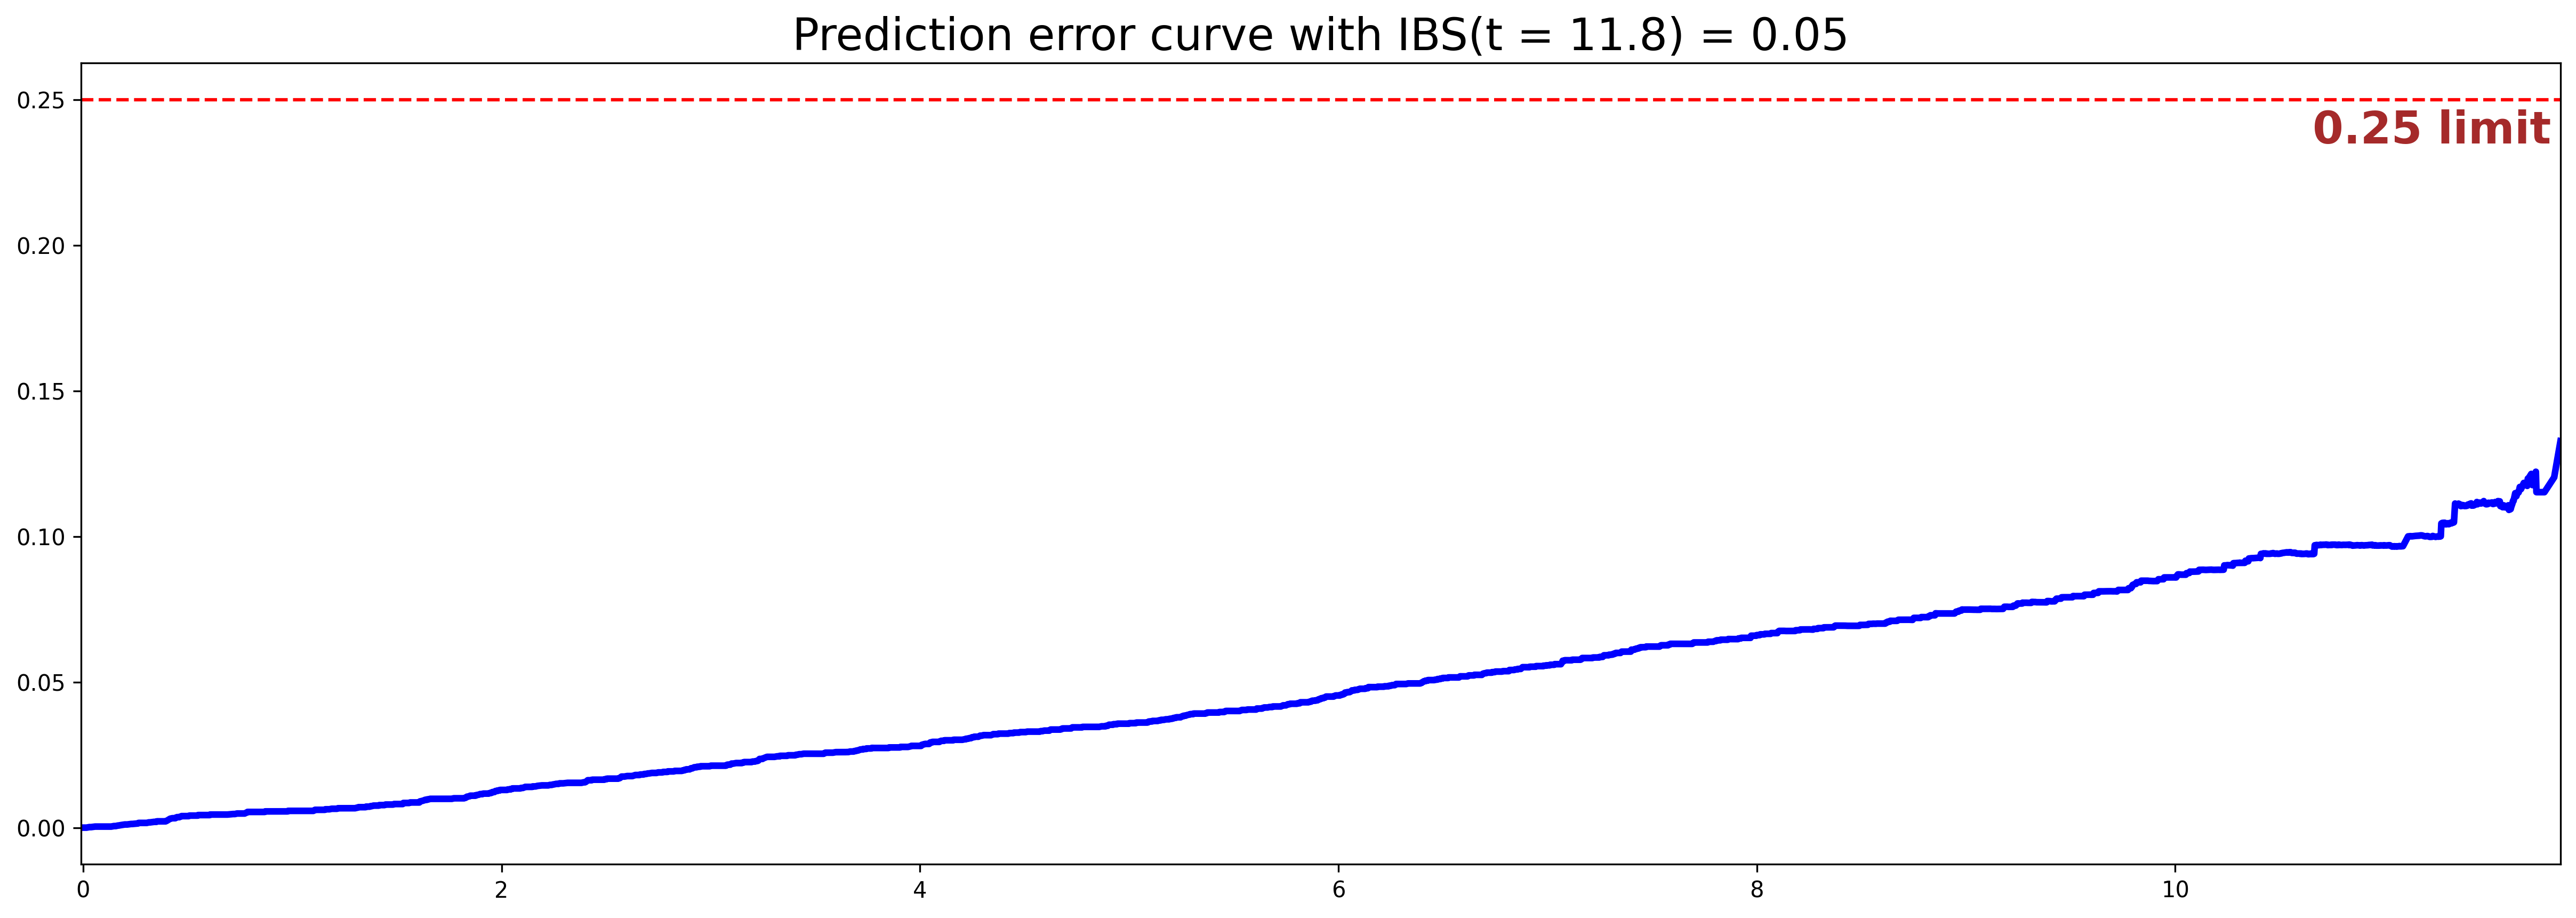

,c-index,IBS,RMSE,MADE,MAE
RSF,0.633146,0.04838,14.586943,10.038687,11.872772


In [35]:
###Model evaluation using testing data
eval_RSF=evaluate(RSF, X_test, T_test, E_test, model_name ="RSF")
eval_RSF

#### 3) Neural Multi-Task Logistic Regression (NMTLR)

In [16]:
###Initialising the model
structure = [ 
                {'activation': 'LogSigmoid', 'num_units': 73}, 
                {'activation': 'Atan', 'num_units': 14},
                {'activation': 'Softsign', 'num_units': 44},
                {'activation': 'Swish', 'num_units': 49},
                {'activation': 'InverseSqrt', 'num_units': 25}   
            ] 
Neural_MTLR = NeuralMultiTaskModel(bins=46, structure=structure)
###Fitting the model using training data
Neural_MTLR.fit(X_train, T_train, E_train,
                optimizer ='rmsprop', lr = 0.00083, num_epochs=693,
                dropout = 0.4, l2_reg = 0.0078, l2_smooth = 0.004,
                batch_normalization = False
                )

% Completion: 100%|**********************************************|Loss: 6776.83


NeuralMultiTaskModel( Layer(1): activation = LogSigmoid, units = 73 ; 
                      Layer(2): activation = Atan, units = 14 ; 
                      Layer(3): activation = Softsign, units = 44 ; 
                      Layer(4): activation = Swish, units = 49 ; 
                      Layer(5): activation = InverseSqrt, units = 25 )

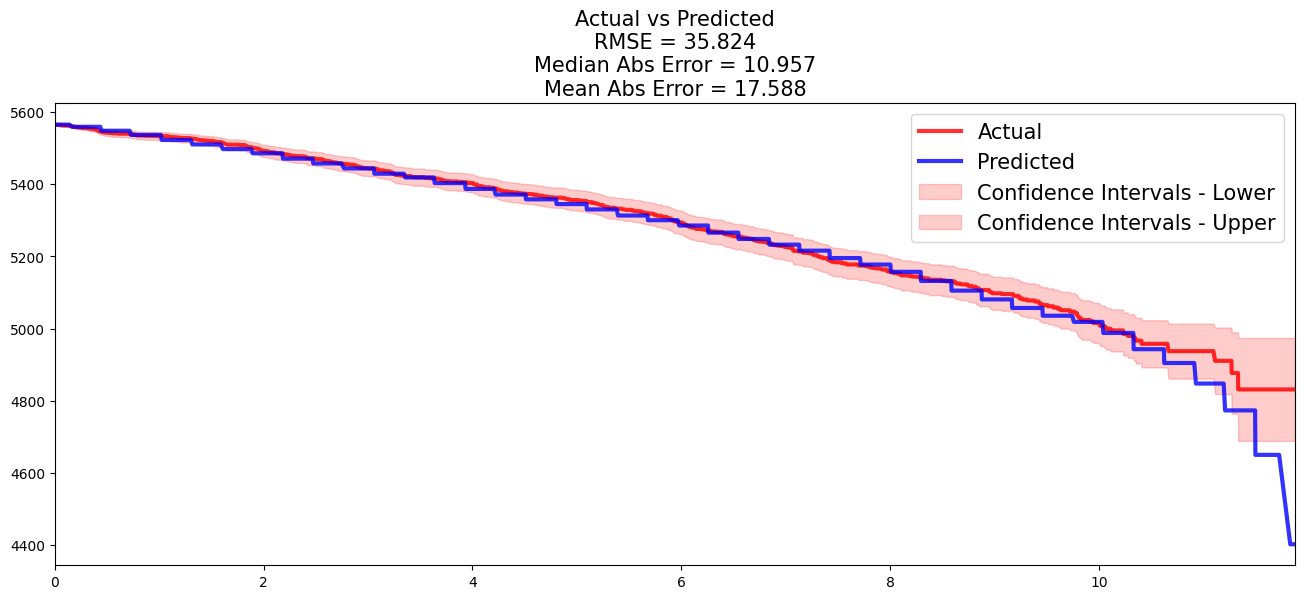

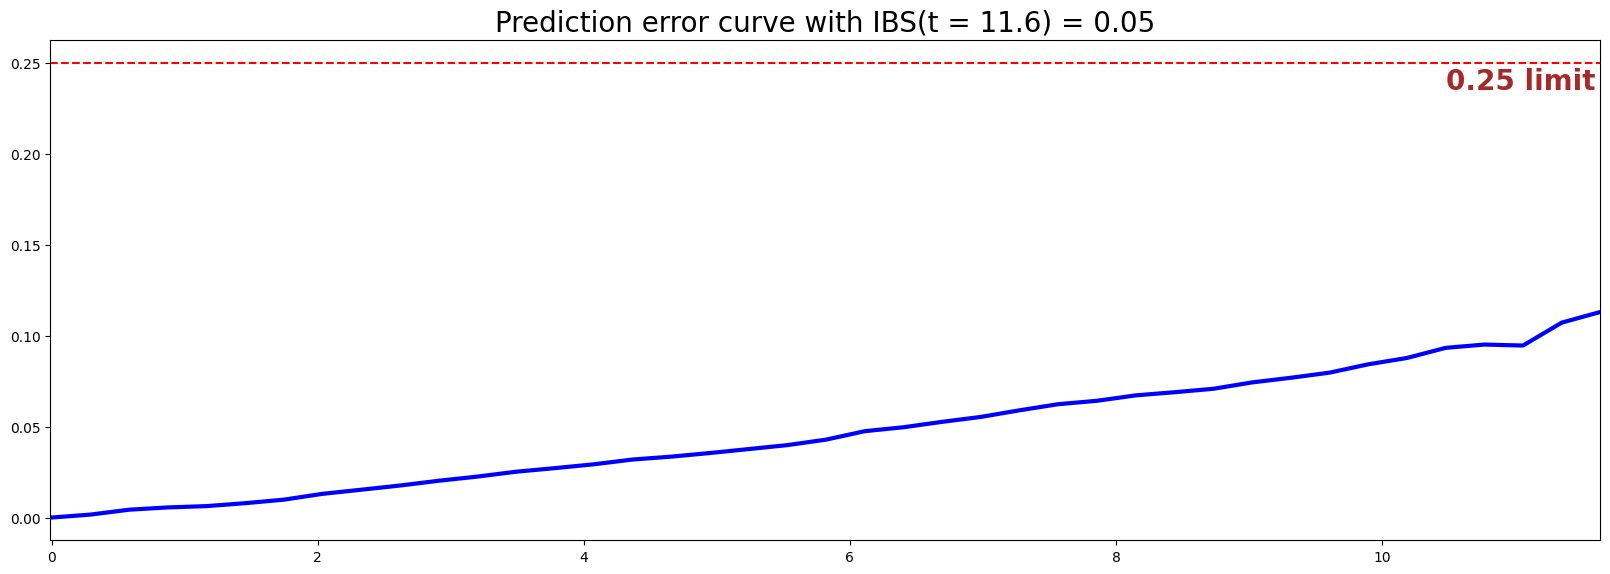

,c-index,IBS,RMSE,MADE,MAE
Neural_MTLR,0.659647,0.046812,35.824129,10.957421,17.587816


In [17]:
###Model evaluation using testing data
eval_Neural_MTLR=evaluate(Neural_MTLR, X_test, T_test, E_test, model_name ="Neural_MTLR")
eval_Neural_MTLR

#### 4) Non-linear Cox proportional hazards (DeepSurv)

In [18]:
###initialising the model
structure1=[{'activation': 'BipolarSigmoid', 'num_units': 13},
           {'activation': 'BipolarSigmoid', 'num_units': 12},
           {'activation': 'Swish', 'num_units': 66},
           {'activation': 'LeCunTanh', 'num_units': 68}
           ]
DeepSurv = NonLinearCoxPHModel(structure=structure1)
# Fitting the model using training data
DeepSurv.fit(X_train, T_train, E_train,
                optimizer = 'sgd', lr = 0.00037, num_epochs=1500,
                dropout = 0.3, l2_reg = 0.0062,
                batch_normalization = False
            )

% Completion: 100%|**********************************************|Loss: 9103.30


NonLinearCoxPHModel( Layer(1): activation = BipolarSigmoid, num_units = 13 ; 
                     Layer(2): activation = BipolarSigmoid, num_units = 12 ; 
                     Layer(3): activation = Swish, num_units = 66 ; 
                     Layer(4): activation = LeCunTanh, num_units = 68 )

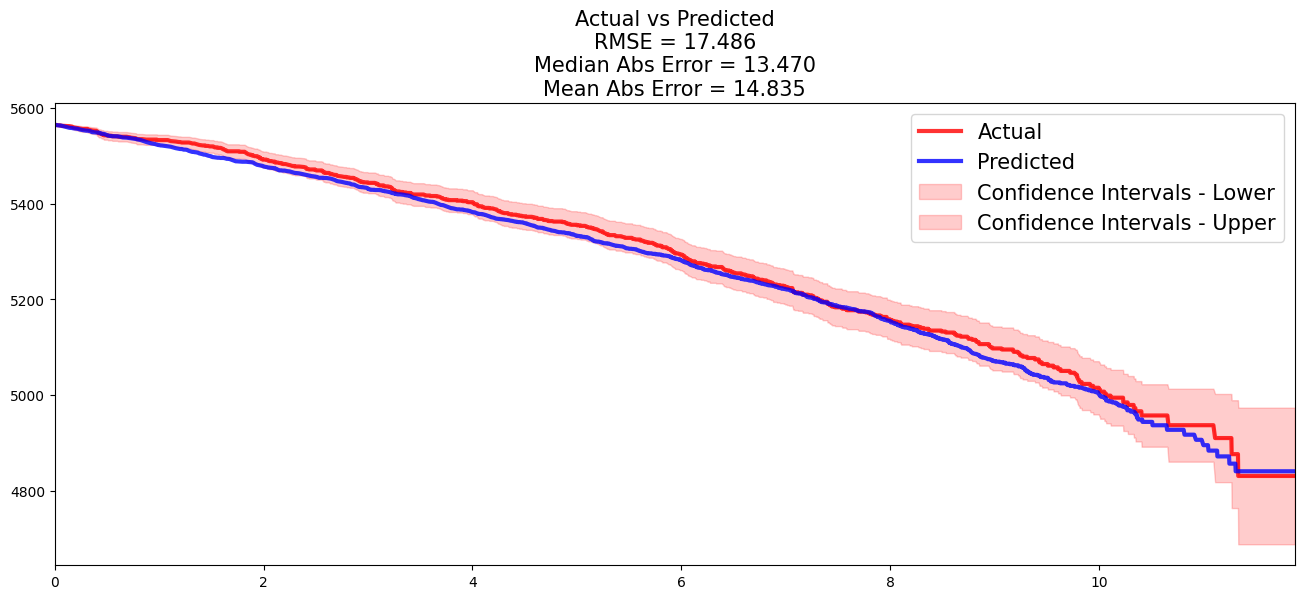

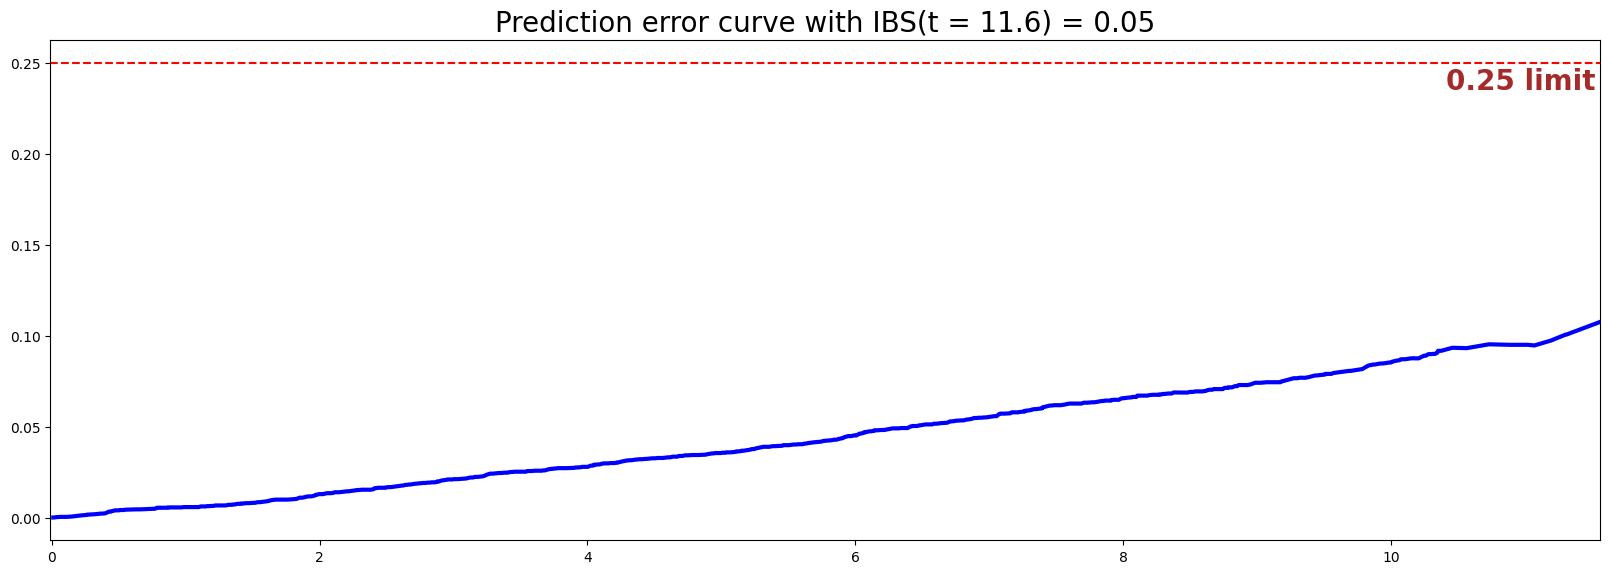

,c-index,IBS,RMSE,MADE,MAE
DeepSurv,0.661202,0.04615,17.485659,13.470029,14.834978


In [19]:
###Model evaluation using test data
eval_DeepSurv=evaluate(DeepSurv, X_test, T_test, E_test, model_name ="DeepSurv")
eval_DeepSurv

In [36]:
eval_all=pd.concat([eval_Cox,eval_RSF, eval_Neural_MTLR, eval_DeepSurv])
eval_all

,c-index,IBS,RMSE,MADE,MAE
Cox,0.634651,0.047579,12.915428,10.458396,10.765946
RSF,0.633146,0.048380,14.586943,10.038687,11.872772
Neural_MTLR,0.659647,0.046812,35.824129,10.957421,17.587816
DeepSurv,0.661202,0.046150,17.485659,13.470029,14.834978


#### Bootstrap method to examine the overlap between the confidence intervals of the C-indices
Overlaping of the confidence intervals of the C-indices do not necessarily mean that the two indices are similar or there is no significant difference between them.

Therfore, pairwise comparision was conducted after bootstraping using 1000 bootstrap sample.
- a significant p-value (<0.05) indicates that the difference between the c-indices is statistically significant 

In [35]:
## Bootstrap method to comapre the c-index 
from sklearn.utils import resample
def bootstrap_c_index(model,X, T, E, n_bootstrap=1000):
    c_indices = []
    for _ in range(n_bootstrap):
        #generate bootstrap sample
        X_boot, T_boot, E_boot = resample(X, T, E)
        
          #Calculate C-index for this sample
        c_index = concordance_index(model,X_boot, T_boot, E_boot)
        c_indices.append(c_index)
    return np.array(c_indices)

In [36]:
## The data was splited into training and testing and All the four models were trained 
#Calculate bootstarp C-index distribution 
Cox_c_indices = bootstrap_c_index(Cox, X_test, T_test, E_test)
rsf_c_indices = bootstrap_c_index(RSF, X_test, T_test, E_test)
NMTLR_c_indices = bootstrap_c_index(Neural_MTLR, X_test, T_test, E_test)
DeepSurv_c_indices = bootstrap_c_index(DeepSurv, X_test, T_test, E_test)

In [39]:
#calculate mean c-index and CI
def summarize_c_index(c_indices):
    mean = np.mean(c_indices)
    ci = np.percentile(c_indices, [2.5, 97.5])
    return mean, ci

cox_mean, cox_ci = summarize_c_index(Cox_c_indices)
rsf_mean, rsf_ci = summarize_c_index(rsf_c_indices)
NMTLR_mean, NMTLR_ci = summarize_c_index(NMTLR_c_indices)
DeepSurv_mean, DeepSurv_ci = summarize_c_index(DeepSurv_c_indices)

print(f"Cox C-index: {cox_mean: .3f} (95%CI: {cox_ci[0]: .3f}-{cox_ci[1]: .3f})")
print(f"RSF C-index: {rsf_mean: .3f} (95%CI: {rsf_ci[0]: .3f}-{rsf_ci[1]: .3f})")
print(f"NMTLR C-index: {NMTLR_mean: .3f} (95%CI: {NMTLR_ci[0]: .3f}-{NMTLR_ci[1]: .3f})")
print(f"DeepSurv C-index: {DeepSurv_mean: .3f} (95%CI: {DeepSurv_ci[0]: .3f}-{DeepSurv_ci[1]: .3f})")

Cox C-index:  0.634 (95%CI:  0.593- 0.675)
RSF C-index:  0.641 (95%CI:  0.595- 0.682)
NMTLR C-index:  0.660 (95%CI:  0.600- 0.712)
DeepSurv C-index:  0.662 (95%CI:  0.603- 0.711)


In [43]:
# perform pairwise comparisions
from scipy import stats
def compare_c_indices(c_indices1, c_indices2):
    t_stat, p_value = stats.ttest_rel(c_indices1, c_indices2)
    return p_value
p_cox_rsf = compare_c_indices(Cox_c_indices, rsf_c_indices)
p_cox_NMTLR = compare_c_indices(Cox_c_indices, NMTLR_c_indices)
p_cox_DeepSurv = compare_c_indices(Cox_c_indices, DeepSurv_c_indices)
p_rsf_NMTLR= compare_c_indices(rsf_c_indices, NMTLR_c_indices)
p_rsf_DeepSurv = compare_c_indices(rsf_c_indices, DeepSurv_c_indices)
p_NMTLR_DeepSurv = compare_c_indices(NMTLR_c_indices, DeepSurv_c_indices)
print(f"Cox vs RSF p-value: {p_cox_rsf: .3f}")
print(f"Cox vs NMTLR p-value: {p_cox_NMTLR: .3f}")
print(f"Cox vs DeepSurv p-value: {p_cox_DeepSurv: .3f}")
print(f"RSF vs NMTLR p-value: {p_rsf_NMTLR: .3f}")
print(f"RSF vs DeepSurv p-value: {p_rsf_DeepSurv: .3f}")
print(f"NMTLR vs DeepSurv p-value: {p_NMTLR_DeepSurv: .3f}")

Cox vs RSF p-value:  0.000
Cox vs NMTLR p-value:  0.000
Cox vs DeepSurv p-value:  0.000
RSF vs NMTLR p-value:  0.000
RSF vs DeepSurv p-value:  0.000
NMTLR vs DeepSurv p-value:  0.127



##### In conclusion

In this study the mean C-index from the bootstrap method and the normal C-index, both based on testing data, were examined. 
The C-indices appear to be similar.

For final reporting, the bootstrap mean C-index was prefered since the bootstrap method allows to calculate the confidence interval and accounts for sampling variability. 

#### Variable importance

In [37]:
### Feature importance plot
for col in X_train:
 print(col)
X_train.columns

Age
Antihypertensive medication use
Diabetes
Gender
HDL_Cholesterol
Non_HDL_cholesterol
Serum creatinine
Smoking
Systolic blood pressure


Index(['Age', 'Antihypertensive medication use', 'Diabetes', 'Gender',
       'HDL_Cholesterol', 'Non_HDL_cholesterol', 'Serum creatinine', 'Smoking',
       'Systolic blood pressure'],
      dtype='object')

In [38]:
####
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [39]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(DeepSurv, X_test, T_test, E_test),
        'NMTLR': variableImportance(Neural_MTLR, X_test, T_test, E_test),
        'RSF': variableImportance(RSF, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                                 DeepSurv     NMTLR       RSF   Average
Age                              0.077966  0.109044  0.110713  0.099241
Antihypertensive medication use -0.006684 -0.003571 -0.001352 -0.003869
Diabetes                        -0.004359 -0.001087 -0.001552 -0.002333
Gender                           0.045069  0.045704  0.072023  0.054265
HDL_Cholesterol                  0.017871 -0.004430 -0.008741  0.001567
Non_HDL_cholesterol              0.033404  0.018542  0.022109  0.024685
Serum creatinine                 0.003146  0.005389 -0.018874 -0.003446
Smoking                          0.037341  0.030404  0.018291  0.028679
Systolic blood pressure          0.015453  0.015218  0.014310  0.014994


C:\Users\ates0004\AppData\Local\Temp\2\ipykernel_10192\3607674480.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=truncate_colormap(cm.get_cmap("Spectral"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-4))


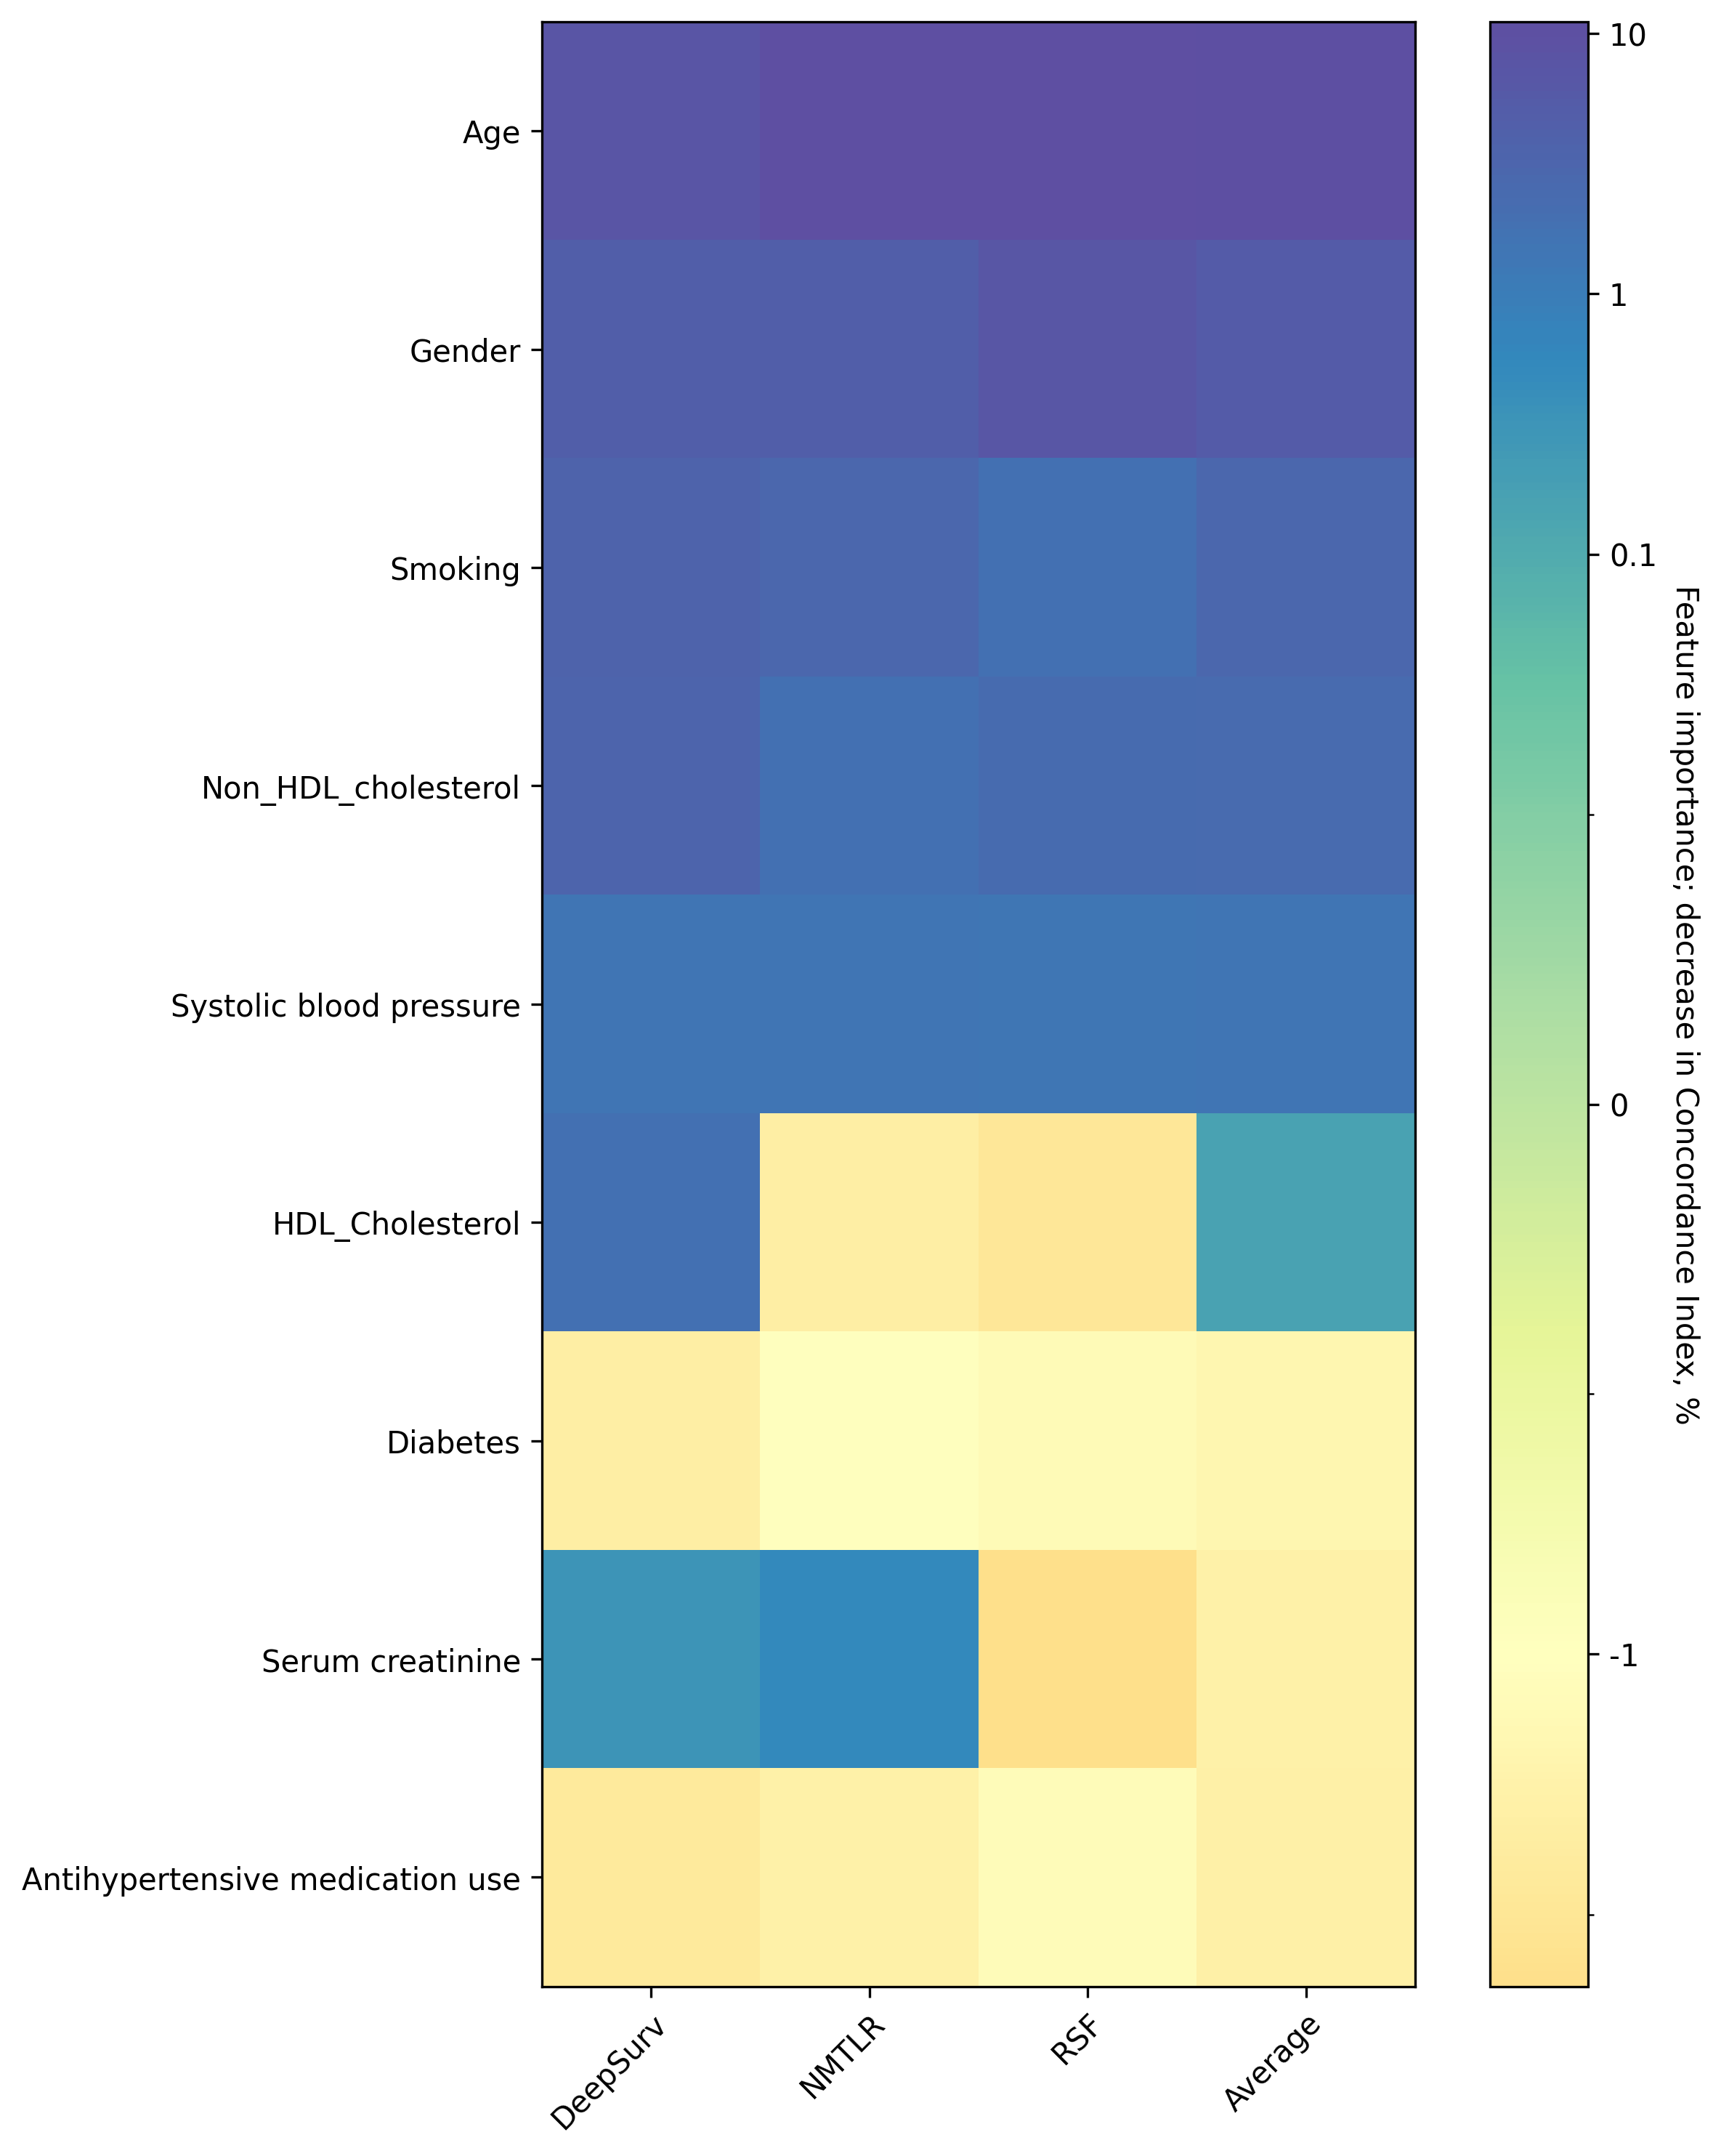

In [40]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))
    
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap
    
    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("Spectral"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-4))
                    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Feature importance; decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])
    
    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF','Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("A:\Objective 3\Replication_Jo_paper\DCA")
    plt.show()
plotFeatureImportance(imp_df)

### Risk score 

#### Using the Cox proportional hazards model

In [25]:
###Risk score
best_model=Cox
risk_profile_Cox=X_test.copy()
risk_profile_Cox['risk_score']=best_model.predict_risk(risk_profile_Cox, use_log=False)

#### Using the Random Survival Forest (RSF)

In [26]:
###Risk score
best_model=RSF
risk_profile_RSF=X_test.copy()
risk_profile_RSF['risk_score']=best_model.predict_risk(risk_profile_RSF, use_log=False)

#### Using the Neural Multi-Task Logistic Regression (NMTLR)

In [27]:
###Risk score
best_model=Neural_MTLR
risk_profile_NMTLR=X_test.copy()
risk_profile_NMTLR['risk_score']=best_model.predict_risk(risk_profile_NMTLR, use_log=False)

#### Using the Non-linear Cox proportional hazards (DeepSurv) model

In [28]:
###Risk score
best_model=DeepSurv
risk_profile_DeepSurv=X_test.copy()
risk_profile_DeepSurv['risk_score']=best_model.predict_risk(risk_profile_DeepSurv, use_log=False)

### Number Needed to Treat (NNT)
 This indicates how many patients need to be treated to prevent one additional adverse outcome, in this case CVD.

In [46]:
time_point = dJh_Final['fyear']
time_point = 10 ## 10 year
cox_predictions = 1-Cox.predict_survival(X_test, t = time_point)
rsf_predictions = 1-RSF.predict_survival(X_test, t = time_point)
NMTLR_predictions = 1-Neural_MTLR.predict_survival(X_test, t = time_point)
DeepSurv_predictions = 1-DeepSurv.predict_survival(X_test, t = time_point)
risk_predictions = {
    'Cox': cox_predictions, 
    'RSF': rsf_predictions,
    'NMTLR': NMTLR_predictions,
    'DeepSurv': DeepSurv_predictions
}

In [47]:
y_true = (T_test <= time_point) & E_test.astype(bool)

In [48]:
#Define a function to calculate NNT
def calculate_NNT (y_true, y_pred, threshold):
    y_true = y_true.astype(bool)
    y_pred = y_pred.ravel()
    predicted_positive = y_pred >=threshold
    true_positive = predicted_positive & y_true
    ppv = np.sum(true_positive)/np.sum(predicted_positive)
    prevalence = np.mean(y_true)
    return 1/(ppv-prevalence)    
NNT_thresholds = [0.05, 0.075, 0.1, 0.2]
NNT_results = {model: [] for model in risk_predictions.keys()}

for threshold in NNT_thresholds:
    for model, y_pred in risk_predictions.items():
        NNT = calculate_NNT(y_true, y_pred, threshold)
        NNT_results[model].append(NNT)
NNT_df = pd.DataFrame(NNT_results, index = NNT_thresholds)

print("Number Needed to Treat(NNT) at the two thresholds:")
print(NNT_df)

Number Needed to Treat(NNT) at the two thresholds:
              Cox         RSF      NMTLR    DeepSurv
0.050  107.636644  246.772260  90.960551  101.625716
0.075   54.828846   56.616950  50.893560   71.261039
0.100   94.679992   27.466103  35.893585   36.270544
0.200   37.913703    9.861641   8.803866   10.372584


#### Saving the models

Since DeepSurv and NMTLR performed better(e.g., interms of C-index and NNT), they were selected for model deployment.
 - These models will be deployed using Streamlit
 - However, the models need to be saved before deployment as follows 

In [49]:
import pickle
##Deepsurv
filename = 'DeepSurv_Jo.pkl'
with open(filename, 'wb') as file:
    pickle.dump(DeepSurv, file)

pickle_inD=open('DeepSurv_Jo.pkl', 'rb')
DeepSurv = pickle.load (pickle_inD)

In [50]:
#NMTLR
filename = 'NMTLR_Jo.pkl'
with open(filename, 'wb') as file:
    pickle.dump(Neural_MTLR, file)

pickle_inN=open('NMTLR_Jo.pkl', 'rb')
NMTLR = pickle.load (pickle_inN)